In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier


In [3]:
customers = pd.read_csv("olist_customers_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv", parse_dates=["order_purchase_timestamp"])
order_items = pd.read_csv("olist_order_items_dataset.csv")
payments = pd.read_csv("olist_order_payments_dataset.csv")
reviews = pd.read_csv("olist_order_reviews_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")

# Parsing dates (important)
orders["order_purchase_timestamp"] = pd.to_datetime(orders["order_purchase_timestamp"], errors="coerce")
orders["order_delivered_customer_date"] = pd.to_datetime(orders["order_delivered_customer_date"], errors="coerce")
orders["order_estimated_delivery_date"] = pd.to_datetime(orders["order_estimated_delivery_date"], errors="coerce")

print(customers.shape, orders.shape, order_items.shape, payments.shape, reviews.shape, products.shape)


(99441, 5) (99441, 8) (112650, 7) (103886, 5) (99224, 7) (32951, 9)


In [4]:
items_agg = (
    order_items.groupby("order_id")
    .agg(
        order_revenue=("price", "sum"),
        order_freight=("freight_value", "sum"),
        nb_items=("order_item_id", "count"),
        nb_products=("product_id", "nunique")
    )
    .reset_index()
)


In [5]:
payments_agg = (
    payments.groupby("order_id")
    .agg(
        payment_value_total=("payment_value", "sum"),
        payment_installments_max=("payment_installments", "max"),
        payment_type_mode=("payment_type", lambda x: x.mode().iloc[0] if len(x.mode()) else x.iloc[0])
    )
    .reset_index()
)


In [6]:
if "review_comment_message" in reviews.columns:
    reviews["review_comment_message"] = reviews["review_comment_message"].fillna("")
    reviews["review_comment_len"] = reviews["review_comment_message"].astype(str).str.len()
else:
    reviews["review_comment_len"] = np.nan

reviews_agg = (
    reviews.groupby("order_id")
    .agg(
        review_score=("review_score", "mean"),
        review_comment_len=("review_comment_len", "mean")
    )
    .reset_index()
)


In [7]:
df = (
    orders.merge(customers, on="customer_id", how="left")
          .merge(items_agg, on="order_id", how="left")
          .merge(payments_agg, on="order_id", how="left")
          .merge(reviews_agg, on="order_id", how="left")
)

print(df.shape)
df.head()


(99441, 21)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,customer_state,order_revenue,order_freight,nb_items,nb_products,payment_value_total,payment_installments_max,payment_type_mode,review_score,review_comment_len
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,SP,29.99,8.72,1.0,1.0,38.71,1.0,voucher,4.0,170.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,BA,118.70,22.76,1.0,1.0,141.46,1.0,boleto,4.0,20.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,GO,159.90,19.22,1.0,1.0,179.12,3.0,credit_card,5.0,0.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,...,RN,45.00,27.20,1.0,1.0,72.20,1.0,credit_card,5.0,105.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,SP,19.90,8.72,1.0,1.0,28.62,1.0,credit_card,5.0,0.0


In [8]:
df.describe()

,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,order_revenue,order_freight,nb_items,nb_products,payment_value_total,payment_installments_max,review_score,review_comment_len
count,99441,96476,99441,99441.000000,98666.000000,98666.000000,98666.000000,98666.000000,99440.000000,99440.000000,98673.000000,98673.000000
mean,2017-12-31 08:43:12.776581120,2018-01-14 12:09:19.035542272,2018-01-24 03:08:37.730111232,35137.474583,137.754076,22.823562,1.141731,1.038098,160.990267,2.930521,4.086793,28.361261
min,2016-09-04 21:15:19,2016-10-11 13:46:32,2016-09-30 00:00:00,1003.000000,0.850000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,2017-09-12 14:46:19,2017-09-25 22:07:22.249999872,2017-10-03 00:00:00,11347.000000,45.900000,13.850000,1.000000,1.000000,62.010000,1.000000,4.000000,0.000000
50%,2018-01-18 23:04:36,2018-02-02 19:28:10.500000,2018-02-15 00:00:00,24416.000000,86.900000,17.170000,1.000000,1.000000,105.290000,2.000000,5.000000,0.000000
75%,2018-05-04 15:42:16,2018-05-15 22:48:52.249999872,2018-05-25 00:00:00,58900.000000,149.900000,24.040000,1.000000,1.000000,176.970000,4.000000,5.000000,42.000000
max,2018-10-17 17:30:18,2018-10-17 13:22:46,2018-11-12 00:00:00,99990.000000,13440.000000,1794.960000,21.000000,8.000000,13664.080000,24.000000,5.000000,208.000000
std,NaN,NaN,NaN,29797.938996,210.645145,21.650909,0.538452,0.226456,221.951257,2.715685,1.346274,48.318765


In [9]:
df.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_revenue                     775
order_freight                     775
nb_items                          775
nb_products                       775
payment_value_total                 1
payment_installments_max            1
payment_type_mode                   1
review_score                      768
review_comment_len                768
dtype: int64

In [10]:
df = df[df["order_status"] == "delivered"].copy()


In [11]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,customer_state,order_revenue,order_freight,nb_items,nb_products,payment_value_total,payment_installments_max,payment_type_mode,review_score,review_comment_len
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,SP,29.99,8.72,1.0,1.0,38.71,1.0,voucher,4.0,170.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,BA,118.70,22.76,1.0,1.0,141.46,1.0,boleto,4.0,20.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,GO,159.90,19.22,1.0,1.0,179.12,3.0,credit_card,5.0,0.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,...,RN,45.00,27.20,1.0,1.0,72.20,1.0,credit_card,5.0,105.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,SP,19.90,8.72,1.0,1.0,28.62,1.0,credit_card,5.0,0.0


In [12]:
df["delivery_delay_days"] = (df["order_delivered_customer_date"] - df["order_purchase_timestamp"]).dt.days

# Retirer les délais négatifs (incohérence)
df = df[df["delivery_delay_days"].notna()]
df = df[df["delivery_delay_days"] >= 0]


In [13]:
# Si payment_value_total manquant : on prend order_revenue + freight (approx), sinon revenue seule
df["order_revenue"] = df["order_revenue"].fillna(0)
df["order_freight"] = df["order_freight"].fillna(0)

fallback_payment = df["order_revenue"] + df["order_freight"]
df["payment_value_total"] = df["payment_value_total"].fillna(fallback_payment)

# Review score : le client peut ne pas noter → imputation moyenne + (optionnel) indicateur manquant
df["review_missing"] = df["review_score"].isna().astype(int)
df["review_score"] = df["review_score"].fillna(df["review_score"].mean())

# Variables item
df["nb_items"] = df["nb_items"].fillna(1)
df["nb_products"] = df["nb_products"].fillna(1)

# Paiement
df["payment_installments_max"] = df["payment_installments_max"].fillna(1)
df["payment_type_mode"] = df["payment_type_mode"].fillna("unknown")


In [16]:
def clip_iqr(s: pd.Series, k: float = 1.5):
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    low = q1 - k * iqr
    high = q3 + k * iqr
    return s.clip(lower=low, upper=high)

# On "clip" plutôt que supprimer pour garder les clients rares
df["order_revenue_clipped"] = clip_iqr(df["order_revenue"])
df["order_freight_clipped"] = clip_iqr(df["order_freight"])
df["delivery_delay_clipped"] = df["delivery_delay_days"].clip(upper=df["delivery_delay_days"].quantile(0.99))


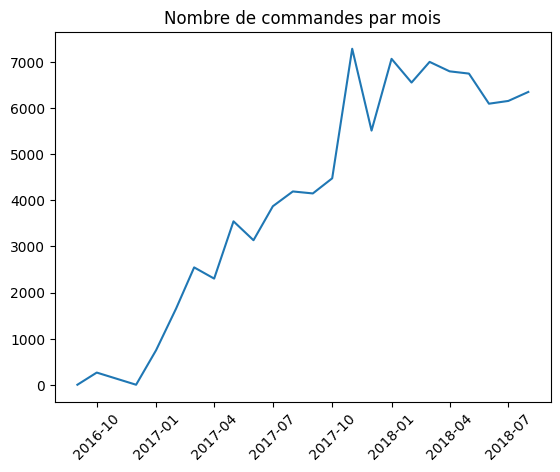

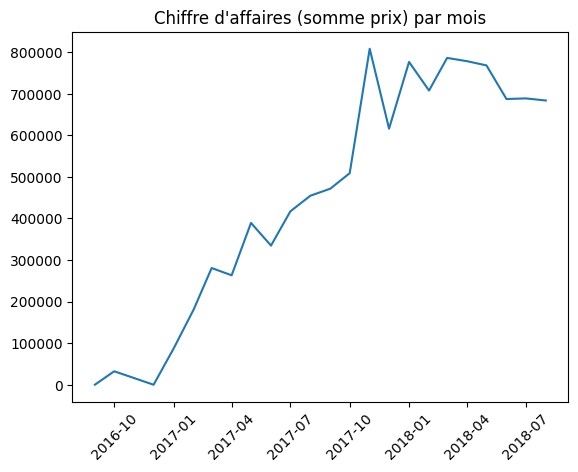

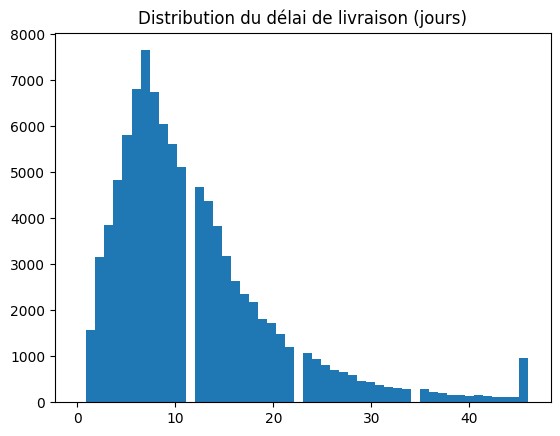

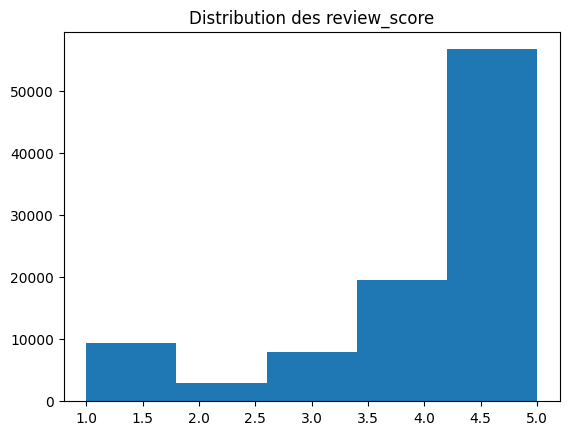

In [17]:
# 6.1 Série temporelle : nb commandes & CA mensuel
df["month"] = df["order_purchase_timestamp"].dt.to_period("M").dt.to_timestamp()

monthly = df.groupby("month").agg(
    orders=("order_id", "nunique"),
    revenue=("order_revenue_clipped", "sum"),
    avg_delay=("delivery_delay_clipped", "mean"),
    avg_review=("review_score", "mean")
).reset_index()

plt.figure()
plt.plot(monthly["month"], monthly["orders"])
plt.title("Nombre de commandes par mois")
plt.xticks(rotation=45)
plt.show()

plt.figure()
plt.plot(monthly["month"], monthly["revenue"])
plt.title("Chiffre d'affaires (somme prix) par mois")
plt.xticks(rotation=45)
plt.show()

# 6.2 Distribution délais & avis
plt.figure()
plt.hist(df["delivery_delay_clipped"], bins=50)
plt.title("Distribution du délai de livraison (jours)")
plt.show()

plt.figure()
plt.hist(df["review_score"], bins=5)
plt.title("Distribution des review_score")
plt.show()
